# Experiment: Using Mask-RCNN for building segmentation from aerial imagery.

### Data preparation

Download the dataset from here:
https://project.inria.fr/aerialimagelabeling/

In [ ]:
%bash
pip install tensorflow==1.12.0
apt install python-opencv -y

In [185]:
import cv2
import numpy as np
import os
import tensorflow as tf
import subprocess
import sys
import tempfile

from PIL import Image

TRAIN_PATH = '../data/train/images'
GT_PATH = '../data/train/gt/'
MASK_PREVIEW_PATH = '../data/train/mask_preview/'
TF_RESEARCH_PATH = '/home/wwoo/github/tensorflow/models/research'
MODEL_CONFIG = 'mask_rcnn_inception_v2_coco.416x416.config'
YOUR_GCS_BUCKET = 'wwoo-test'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz'
JOB_POSTFIX = '416x416'

# Make sure you create these directories first
TRAIN_TILED_PATH = os.path.join(TRAIN_PATH, '../tiled_images_416')
GT_TILED_PATH = os.path.join(GT_PATH, '../tiled_gt_416')

TILE_X = 12
TILE_Y = 12

sys.path.append(TF_RESEARCH_PATH)
from object_detection.utils import dataset_util

# This is needed to display the images.
%matplotlib inline

In [186]:
os.environ['YOUR_GCS_BUCKET'] = YOUR_GCS_BUCKET
os.environ['TF_RESEARCH_PATH'] = TF_RESEARCH_PATH
os.environ['PRETRAINED_MODEL_URL'] = PRETRAINED_MODEL_URL
os.environ['MODEL_CONFIG'] = MODEL_CONFIG
os.environ['JOB_POSTFIX'] = JOB_POSTFIX

In [58]:
def load_image_from_path(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    h, w = img.shape[:2]    
    return h, w, img


def tile_image(img, dest_dir, tile_prefix, x_num, y_num):
    h, w = img.shape[:2]
    tile_w = int(float(w)/float(x_num)) # tile width
    tile_h = int(float(h)/float(y_num)) # tile height
    counter = 0
    
    for x in range(x_num):
        for y in range(y_num):
            counter += 1
            tile_img = img[x*tile_w:(x+1)*tile_w, y*tile_h:(y+1)*tile_h]
            dest_file = os.path.join(dest_dir, tile_prefix + '-' + str(counter) + '.png')
            cv2.imwrite(dest_file, tile_img)
    

def get_bounding_boxes(img, preview_path=None, preview_scale=1.0):
    img_h, img_w = img.shape[:2]
    ret, threshed_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img_orig, contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE)

    for i in range(len(contours)):
        c = contours[i]
        x, y, w, h = cv2.boundingRect(c) # bounding box rect
        # img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        top_x, top_y = float(x)/float(img_w), float(y)/float(img_h)
        bottom_x, bottom_y = top_x+(float(w)/float(img_w)), top_y+(float(h)/float(img_h))
        
        cimg = np.zeros_like(img)
        cv2.drawContours(cimg, contours, i, color=255, thickness=-1)
        
        '''
        x_pts, y_pts = np.where(cimg == 255)
        mask = np.zeros_like(img)
        mask[x_pts, y_pts] = 255
        '''
        
        if preview_path is not None:
            img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            resized_img = cv2.resize(img, None,fx=preview_scale, fy=preview_scale)
            cv2.imwrite(preview_path, resized_img)
        
        yield top_x, top_y, bottom_x, bottom_y, cimg


def encode_image(img):
    img_str = cv2.imencode('.png', img)[1].tostring()
    return img_str

The source images are 5000*5000. Split the source images and masks into smaller tiles.

In [59]:
def generate_tiled_images(source_dir, dest_dir, x_num=TILE_X, y_num=TILE_Y):
    file_paths = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    for fp in file_paths:
        h, w, img = load_image_from_path(os.path.join(source_dir, fp))
        tile_image(img, dest_dir, fp.replace('.tif', ''), x_num, y_num)
        

# Tile source images
generate_tiled_images(TRAIN_PATH, TRAIN_TILED_PATH, x_num=TILE_X, y_num=TILE_Y)    

# Tile masks
generate_tiled_images(GT_PATH, GT_TILED_PATH, x_num=TILE_X, y_num=TILE_Y)

Create serialized examples and write to TFRecords. 

For each ground truth mask file, we need to split each mask instance (that is, individual masks within a single mask PNG) into it's own mask PNG and store with each example.  We then calculate a bounding boxes for each mask instance.

In [60]:
def create_tf_examples(train_dir=TRAIN_PATH, gt_dir=GT_PATH, preview_dir=None):
    train_file_paths = [f for f 
                    in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]

    for f in train_file_paths:
        try:
            # Source image and mask should be the same filename, but different directories
            img_h, img_w, img = load_image_from_path(os.path.join(train_dir, f))
            mask_h, mask_w, mask_img = load_image_from_path(os.path.join(gt_dir, f))
            img_str = encode_image(img)
            xmins, xmaxs, ymins, ymaxs, masks = [], [], [], [], []

            for top_x, top_y, bottom_x, bottom_y, mask in get_bounding_boxes(mask_img, os.path.join(preview_dir, f)):
                xmins.append(top_x)
                ymins.append(top_y)
                xmaxs.append(bottom_x)
                ymaxs.append(bottom_y)
                masks.append(encode_image(mask))
                
            classes_text = ['building' for i in range(len(xmins))]
            classes = [1 for i in range(len(xmins))]

            tf_example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': dataset_util.int64_feature(img_h),
                'image/width': dataset_util.int64_feature(img_w),
                'image/filename': dataset_util.bytes_feature(f),
                'image/source_id': dataset_util.bytes_feature(f),
                'image/encoded': dataset_util.bytes_feature(img_str),
                'image/object/mask': dataset_util.bytes_list_feature(masks),
                'image/format': dataset_util.bytes_feature(b'png'),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes),
            }))

            yield tf_example        
            
        except:
            print('Error processing file: {}'.format(f))
            continue

Bake TFRecords from the tiled source images and masks.  The code also calculates bounding boxes from the ground truth masks.  

The overall process can take awhile (TODO: turn this into a Beam pipeline)

In [61]:
import contextlib2 # pip install contextlib2
from object_detection.dataset_tools import tf_record_creation_util

NUM_SHARDS=10
OUTPUT_FILEBASE='../output_416/train_dataset.record'

with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
        tf_record_close_stack, OUTPUT_FILEBASE, NUM_SHARDS)
    
    for index, tf_example in enumerate(create_tf_examples(train_dir=TRAIN_TILED_PATH, gt_dir=GT_TILED_PATH, preview_dir=MASK_PREVIEW_PATH)):
        output_shard_index = index % NUM_SHARDS
        output_tfrecords[output_shard_index].write(tf_example.SerializeToString())

Let's have a look at the calculated bounding boxes from our mask preview images.

In [ ]:
%%bash
ls ../data/train/mask_preview

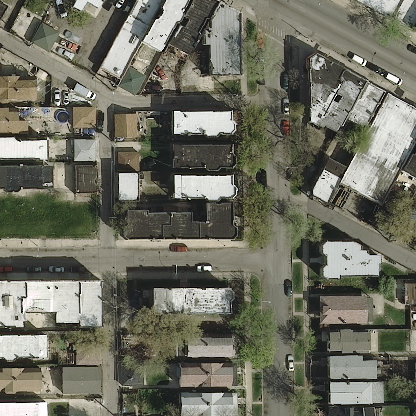

In [81]:
Image.open(os.path.join(TRAIN_TILED_PATH, 'chicago6-4.png'))

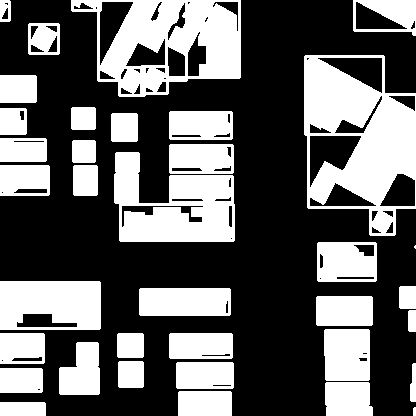

In [82]:
Image.open(os.path.join(MASK_PREVIEW_PATH, 'chicago6-4.png'))

List our generated TFRecord files.

In [113]:
%%bash
ls -l ../output_416

total 9272220
-rw-r--r-- 1 wwoo primarygroup 952244742 Nov 26 17:22 eval_dataset.record
-rw-r--r-- 1 wwoo primarygroup 951057238 Nov 26 17:22 train_dataset.record-00000-of-00010
-rw-r--r-- 1 wwoo primarygroup 949536006 Nov 26 17:22 train_dataset.record-00001-of-00010
-rw-r--r-- 1 wwoo primarygroup 946432511 Nov 26 17:22 train_dataset.record-00002-of-00010
-rw-r--r-- 1 wwoo primarygroup 946811145 Nov 26 17:22 train_dataset.record-00003-of-00010
-rw-r--r-- 1 wwoo primarygroup 949983747 Nov 26 17:22 train_dataset.record-00004-of-00010
-rw-r--r-- 1 wwoo primarygroup 944231414 Nov 26 17:22 train_dataset.record-00005-of-00010
-rw-r--r-- 1 wwoo primarygroup 948794687 Nov 26 17:22 train_dataset.record-00006-of-00010
-rw-r--r-- 1 wwoo primarygroup 955012217 Nov 26 17:22 train_dataset.record-00007-of-00010
-rw-r--r-- 1 wwoo primarygroup 950583712 Nov 26 17:22 train_dataset.record-00008-of-00010


Pick one of the TFRecord files for evaluation. We're not really worried about which one to choose (but we should probably be more clever about ensuring a mix of image types).

In [65]:
%%bash
LAST_TRAIN_FILE=`ls ../output_416 | tail -1`
mv ../output_416/${LAST_TRAIN_FILE} ../output_416/eval_dataset.record

### Model training on CMLE

Before running anything below, make sure you have followed the steps to install TensorFlow Object Detection API:
[https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md]

In [175]:
TAR_FILE=`echo "${PRETRAINED_MODEL_URL##*/}"`
UNTAR_DIR="${TAR_FILE%.tar.gz}"
NOTEBOOK_DIR=`pwd`

echo "======================================================"
echo "Copying datasets to GCS ..."
gsutil -m cp ../output_416/* gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/tfrecords/
gsutil cp label.pbtxt gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/tfrecords/
echo "======================================================"

echo "======================================================"
echo "Copying model config to GCS ..."
gsutil cp ${MODEL_CONFIG} gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/checkpoint/
echo "======================================================"

# Download model checkpoint
if [ ! -f  $TAR_FILE ]; then
    echo "======================================================"
    echo "Downloading model checkpoint ..."
    wget ${PRETRAINED_MODEL_URL}
    echo "======================================================"
fi

echo "======================================================"
echo "Untar model checkpoint and upload to GCS ..."
tar -zxvf $TAR_FILE
gsutil -m cp ${UNTAR_DIR}/model.ckpt.* gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/checkpoint/
echo "======================================================"

cd ${TF_RESEARCH_PATH}

if [ ! -f  protobuf.zip ]; then
    echo "======================================================"
    echo "Downloading protoc ..."
    wget -O protobuf.zip https://github.com/google/protobuf/releases/download/v3.0.0/protoc-3.0.0-linux-x86_64.zip
    echo "======================================================"
fi

echo "======================================================"
echo "Unzip protoc and generate required protos ..."
unzip -o protobuf.zip
./bin/protoc object_detection/protos/*.proto --python_out=.

echo "======================================================"
echo "Packaging code ..."
bash object_detection/dataset_tools/create_pycocotools_package.sh /tmp/pycocotools
python setup.py sdist
(cd slim && python setup.py sdist)
echo "======================================================"

# Use our custom pipeline config instead.
# We will use TF 1.9 due to this issue: https://github.com/tensorflow/models/issues/5056

echo "======================================================"
echo "Copying job config to GCS ..."
cp ${NOTEBOOK_DIR}/cloud_custom.yml ${TF_RESEARCH_PATH}/object_detection/samples/cloud/cloud_custom.yml
echo "======================================================"

echo "======================================================"
echo "Launching training on CMLE ..."
gcloud ml-engine jobs submit training `whoami`_${UNTAR_DIR}_`date +%m_%d_%Y_%H_%M_%S`_${JOB_POSTFIX} \
    --runtime-version 1.9 \
    --job-dir=gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/model/ \
    --packages dist/object_detection-0.1.tar.gz,slim/dist/slim-0.1.tar.gz,/tmp/pycocotools/pycocotools-2.0.tar.gz \
    --module-name object_detection.model_main \
    --region us-central1 \
    --config object_detection/samples/cloud/cloud_custom.yml \
    -- \
    --model_dir=gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/model/ \
    --pipeline_config_path=gs://${YOUR_GCS_BUCKET}/${UNTAR_DIR}_${JOB_POSTFIX}/checkpoint/${MODEL_CONFIG}
echo "======================================================"

Copying datasets to GCS ...
Copying file://../output_416/eval_dataset.record [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00000-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00003-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00002-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00001-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00004-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00007-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00006-of-00010 [Content-Type=application/octet-stream]...
Copying file://../output_416/train_dataset.record-00008-of-00010 [Content-Type=application/octet-stream]...
Copying file://.

copying object_detection/anchor_generators/multiscale_grid_anchor_generator_test.py -> object_detection-0.1/object_detection/anchor_generators
copying object_detection/box_coders/__init__.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/faster_rcnn_box_coder.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/faster_rcnn_box_coder_test.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/keypoint_box_coder.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/keypoint_box_coder_test.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/mean_stddev_box_coder.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/mean_stddev_box_coder_test.py -> object_detection-0.1/object_detection/box_coders
copying object_detection/box_coders/square_box_coder.py -> object_dete

copying object_detection/models/faster_rcnn_nas_feature_extractor.py -> object_detection-0.1/object_detection/models
copying object_detection/models/faster_rcnn_nas_feature_extractor_test.py -> object_detection-0.1/object_detection/models
copying object_detection/models/faster_rcnn_pnas_feature_extractor.py -> object_detection-0.1/object_detection/models
copying object_detection/models/faster_rcnn_pnas_feature_extractor_test.py -> object_detection-0.1/object_detection/models
copying object_detection/models/faster_rcnn_resnet_v1_feature_extractor.py -> object_detection-0.1/object_detection/models
copying object_detection/models/faster_rcnn_resnet_v1_feature_extractor_test.py -> object_detection-0.1/object_detection/models
copying object_detection/models/feature_map_generators.py -> object_detection-0.1/object_detection/models
copying object_detection/models/feature_map_generators_test.py -> object_detection-0.1/object_detection/models
copying object_detection/models/ssd_feature_extracto

copying object_detection/utils/shape_utils.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/shape_utils_test.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/static_shape.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/static_shape_test.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/test_case.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/test_utils.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/test_utils_test.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/variables_helper.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/variables_helper_test.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/visualization_utils.py -> object_detection-0.1/object_detection/utils
copying object_detection/utils/vis

Run Tensorboard.

In [ ]:
%%bash

## MODIFY THE FOLLOWING
LOG_DIR=gs://wwoo-test/mask_rcnn_resnet101_atrous_coco_1000x1000_416x416/model/
## END MODIFICATIONS

tensorboard --logdir ${LOG_DIR}

[Click here to access tensorboard](http://localhost:6006).

Export the trained model.  Make sure to change \_\_TRAINED\_MODEL\_CHECKPOINT\_\_ to the path prefix of your checkpoint file.

In [134]:
%%bash
NOTEBOOK_DIR=`pwd`
mkdir -p ${NOTEBOOK_DIR}/../exported_model
cp ${MODEL_CONFIG} ${TF_RESEARCH_PATH}
cd __TF_RESEARCH_PATH__
PYTHONPATH=${TF_RESEARCH_PATH}:${TF_RESEARCH_PATH}/slim/ python object_detection/export_inference_graph.py \
    --input_type='image_tensor' \
    --pipeline_config_path=${MODEL_CONFIG} \
    --trained_checkpoint_prefix='gs://wwoo-test/mask_rcnn_inception_v2_coco_2018_01_28_416x416/model/model.ckpt-201524' \
    --output_directory=${NOTEBOOK_DIR}/../exported_model

Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1127 17:56:59.744565 140669014411008 tf_logging.py:125] From /usr/local/google/home/wwoo/github/tensorflow/models/research/object_detection/predictors/heads/box_head.py:93: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1127 17:57:00.360398 140669014411008 tf_logging.py:125] From /usr/local/google/home/wwoo/github/tensorflow/models/research/object_detection/exporter.py:328: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build

252 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*,.*Initializer.*,.*Regularizer.*,.*BiasAdd.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================
Incomplete shape.

Doc:
scope: The nodes in the model graph are organiz

2018-11-27 17:57:02.729119: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


## Visualizing predictions

The following cells are basically a straight copy of the relevant parts of object_detection_tutorial.ipynb.

In [181]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from matplotlib import pyplot as plt

PATH_TO_LABELS='label.pbtxt'
PATH_TO_FROZEN_GRAPH='../exported_model/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


TEST_IMAGE_PATHS = [os.path.join(TRAIN_TILED_PATH, 'vienna1-16.png')]

# Size, in inches, of the output images.
IMAGE_SIZE = (50, 50)

In [182]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

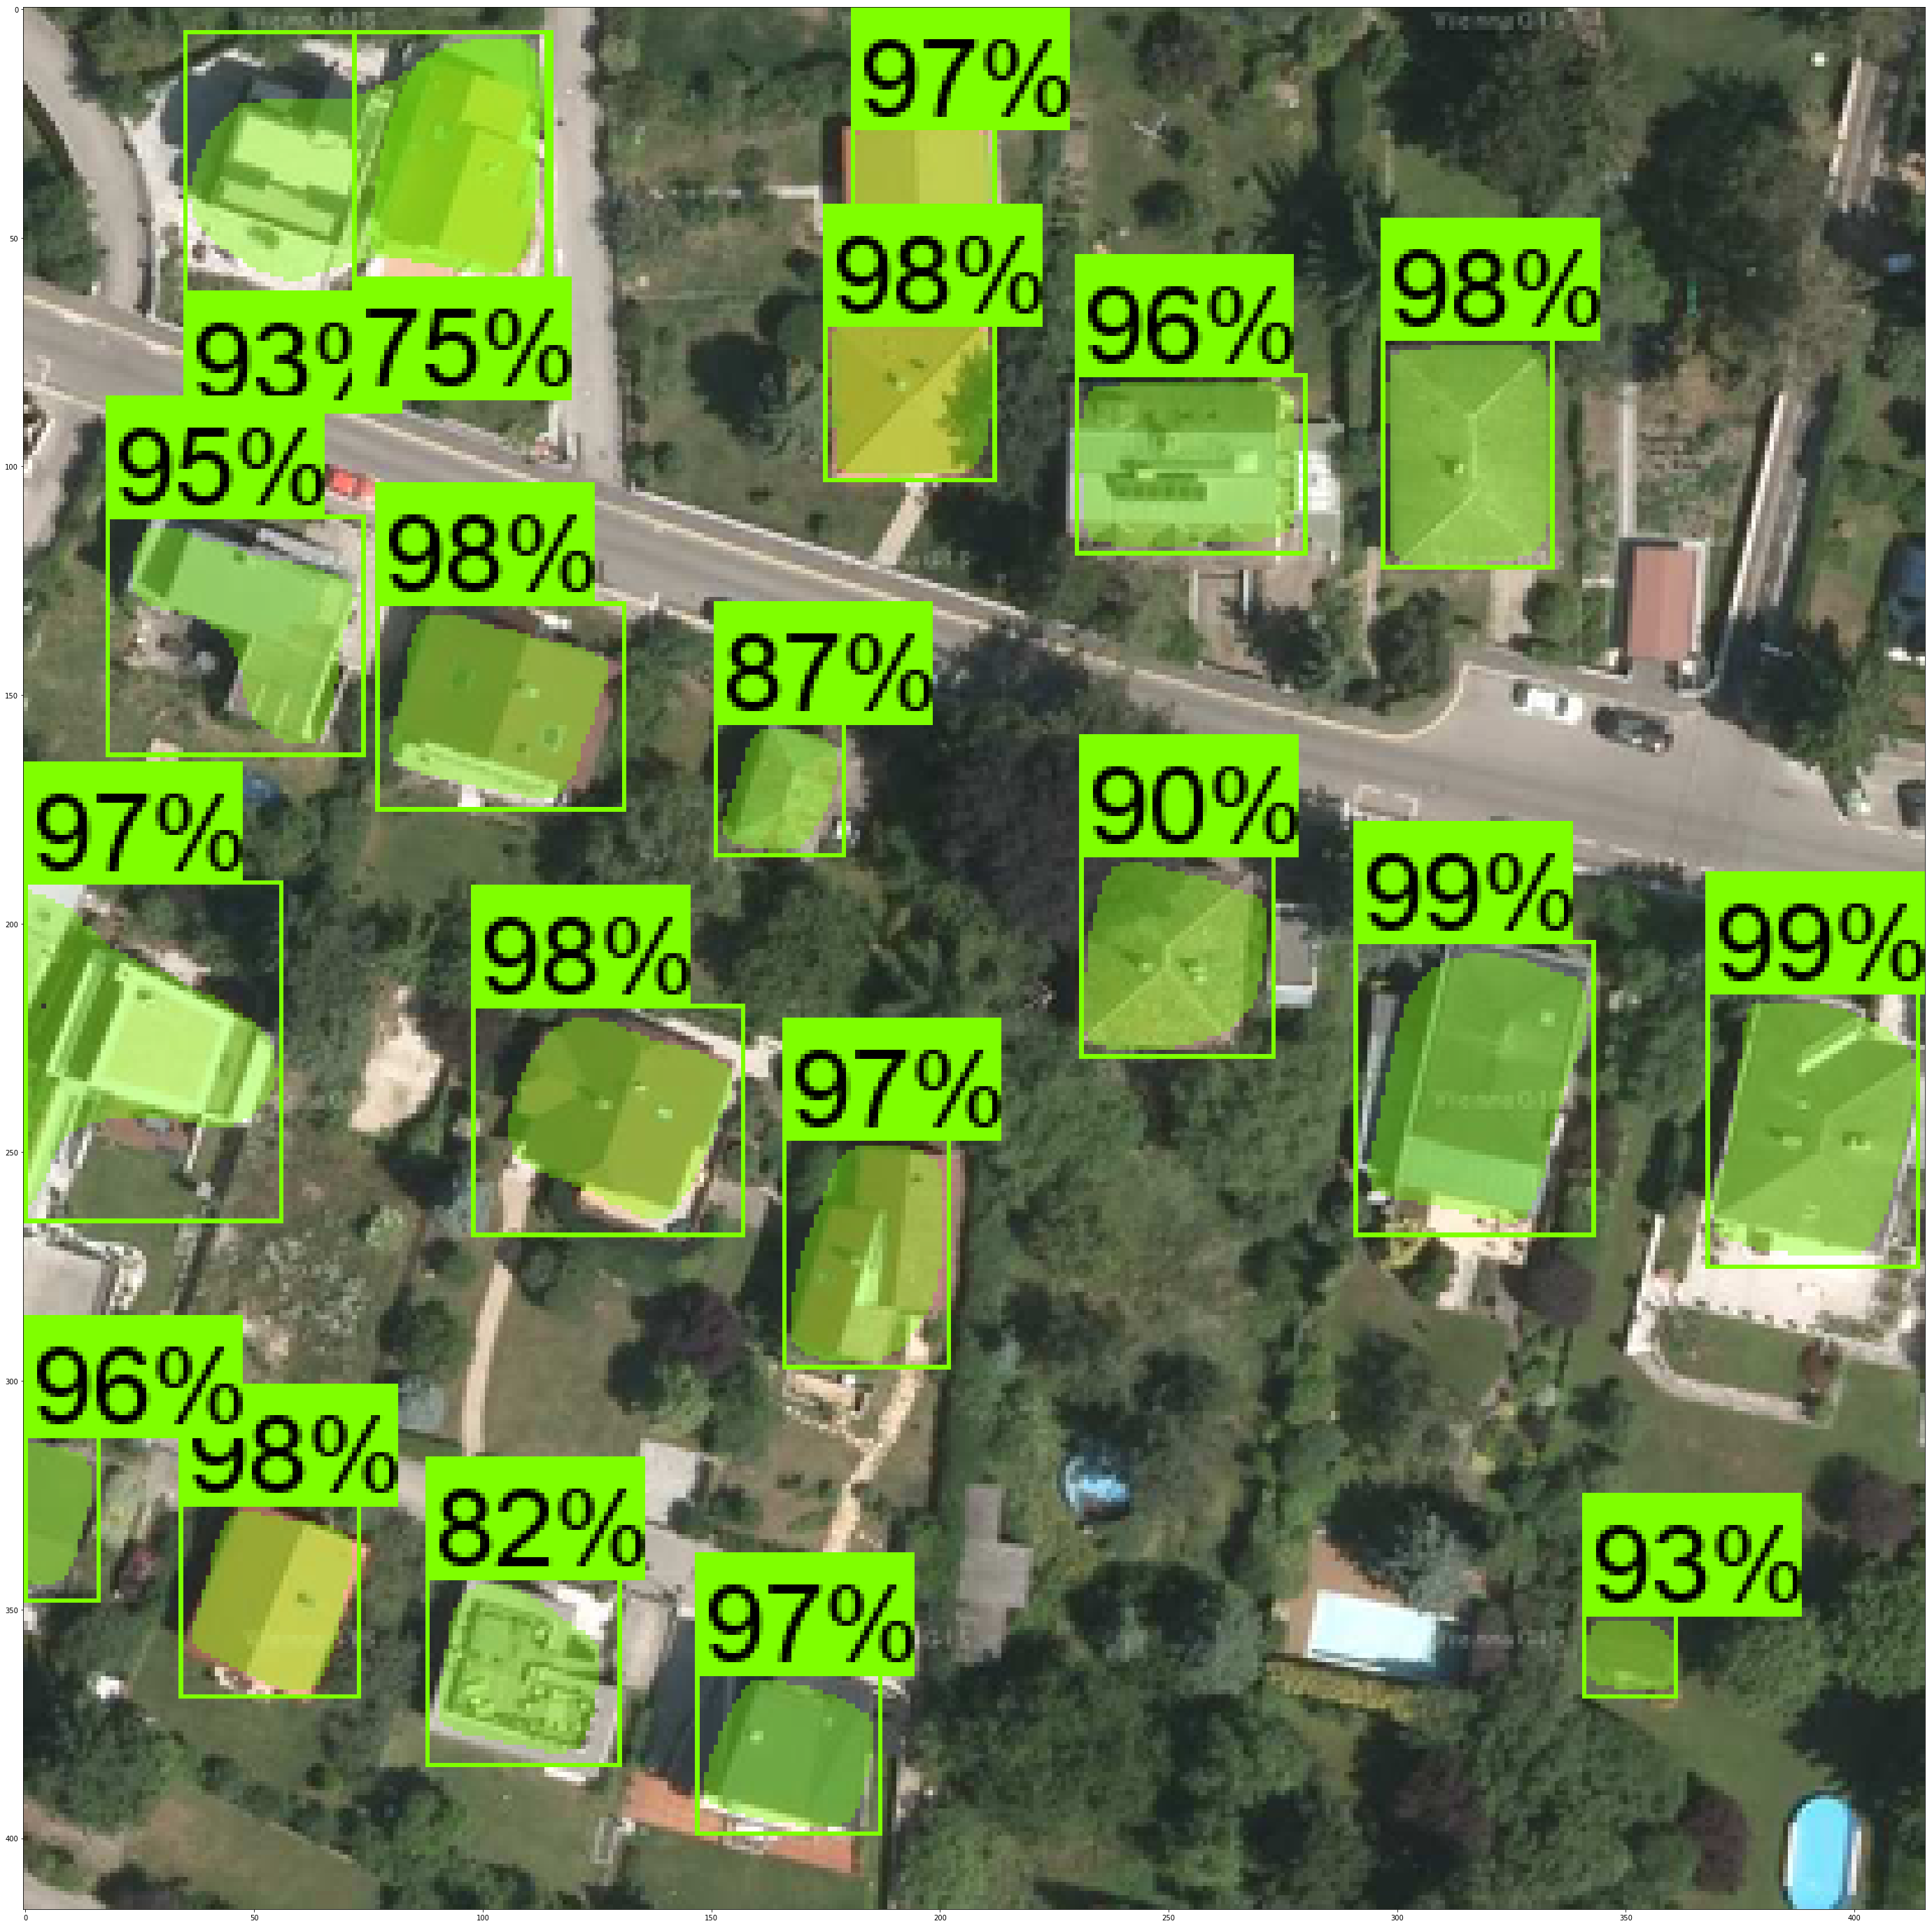

In [183]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  annotated_image = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=0,
      min_score_thresh=0.0,
      skip_labels=True)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(annotated_image)